In [1]:
import copra
import matplotlib.pyplot as pl

In [22]:
# get synthetic model measurements
model, dataframes = copra.synthcore(M=30, ae_top=10, ae_bot=500, ae_incr="exp")
age_df, proxy_df = dataframes[0], dataframes[1]

simulate logistic growth of sedimentary archive ...
simulate proxy signal as noisy sinusoid ...
create dictionary for model ...
create DataFrame from dictionary ...
make age measurements ...
make proxy measurements ...
create dictionaries for model and measurements ...
create dataframes from dictionaries ...


In [23]:
# run COPRA
agemods = copra.agemodels(age_df, proxy_df, nens=100, extrapolate=True)
prxrecs = copra.proxyrecords(agemods, proxy_df, ageres=20, agelims=(100, 9500))

while loop ...


In [24]:
# remove time points with NaNs
num_nans = copra.np.isnan(prxrecs.iloc[:, 1:].to_numpy()).sum(axis=1)
nonan_idx = np.where(num_nans == 0)[0]
prxrecs = prxrecs.iloc[nonan_idx]

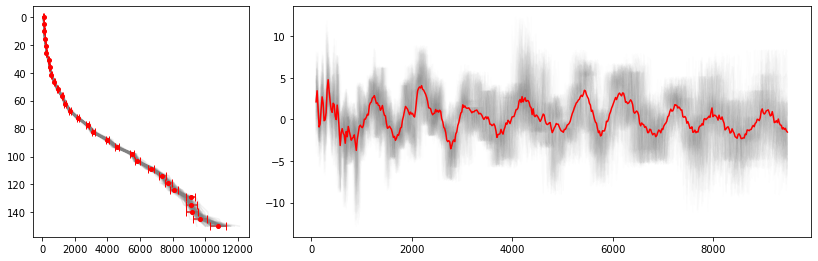

In [25]:
# plot results
fig = pl.figure(figsize=[12., 4.])
ax1 = fig.add_axes([0.05, 0.10, 0.25, 0.80])
ax2 = fig.add_axes([0.35, 0.10, 0.60, 0.80])
ax1.plot(agemods.iloc[:, 1:], agemods['depth'], "-", c="0.5", alpha=0.10)
ax1.errorbar(age_df['age'], age_df['depth'], xerr=age_df['error'], fmt="ro",
             capsize=4, ms=4)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.plot(prxrecs['age'], prxrecs.iloc[:, 1:], "-", c="0.5", ms=2, alpha=0.01)
ax2.plot(prxrecs['age'], prxrecs.iloc[:, 1:].mean(axis=1), "-", c="r")

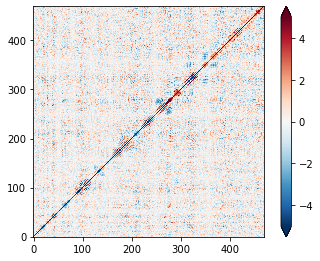

In [27]:
# covariance function
precs = prxrecs.iloc[:, 1:].to_numpy()
cov = copra.np.cov(precs)

fig = pl.figure()
ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
im = ax.imshow(cov, cmap="RdBu_r", origin="lower", vmin=-5, vmax=5)
pl.colorbar(im, extend="both")

In [28]:
d = 1
l = 5
sigma_f = 50

prxs = prxrecs.iloc[:, 1:].to_numpy()
prx_mean = copra.np.nanmean(prxs, axis=1)
prx_err = copra.np.nanstd(prxs, axis=1)

x = prxrecs["age"].to_numpy()
y = prx_mean
sigma_n = prx_err
x_star = np.linspace(x[0]-1000, x[-1] + 1001, 1000)

Text(0.5, 1.0, 'i = 9')

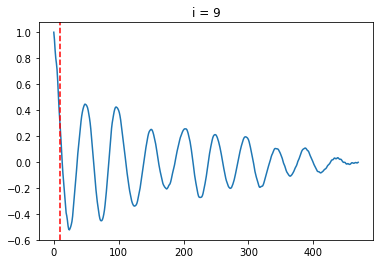

In [29]:
acf = copra.np.correlate(y, y, mode="full")[len(y) - 1:]
acf /= acf.max()
i = np.where(acf < 1 / np.exp(1))[0][0]
pl.plot(acf)
pl.axvline(i, ls="--", c="r")
pl.title("i = %d" % i)

In [30]:
# use scikit learn to get the same results
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# Define kernel parameters. 
l = np.mean(np.diff(x))
sigma_f = (y.max() - y.min()) ** 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3))

# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2,
                              optimizer=None, n_restarts_optimizer=50)

# format data acc to the shapes needed
X = prxrecs["age"].to_numpy().reshape(len(x), d)
X_star = x_star.reshape(len(x_star), d)

# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)

# sample from the posterior
nsamp = 100
samples = gp.sample_y(X_star, nsamp)

# Make the prediction on test set, i.e. sample posterior mean
y_pred, cov_pred = gp.predict(X_star, return_cov=True)

# get credible intervals
y_bar = samples.mean(axis=1)
y_std = samples.std(axis=1)



(-25, 25)

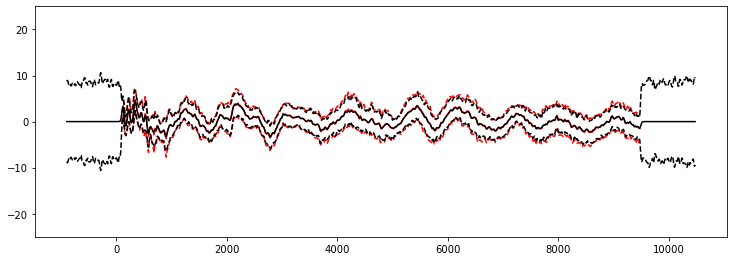

In [31]:

fig = pl.figure(figsize=[12., 4.])
ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
# ax.plot(prxrecs['age'], prxrecs.iloc[:, 1:], "-", c="r", ms=2, alpha=0.005)
ax.plot(prxrecs['age'], prx_mean, "r-")
ax.plot(prxrecs['age'], prx_mean + prx_err, "r--")
ax.plot(prxrecs['age'], prx_mean - prx_err, "r--")
# ax.plot(X_star, samples, "-", c="0.5", alpha=0.15)
ax.plot(X_star, y_pred, "-", c="k")
ax.plot(X_star, y_pred + y_std, "k--")
ax.plot(X_star, y_pred - y_std, "k--")
ax.set_ylim(-25, 25)

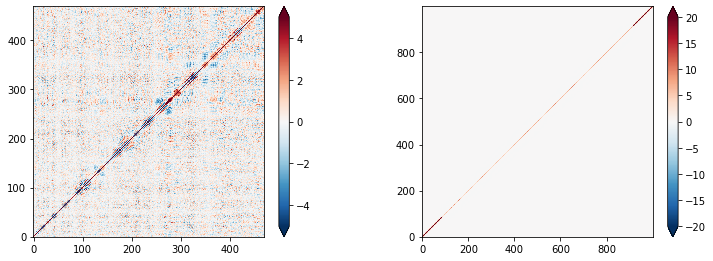

In [32]:
# look at the covariance functions
fig = pl.figure(figsize=[12., 4.])
ax1 = fig.add_axes([0.10, 0.10, 0.35, 0.80])
im1 = ax1.imshow(cov, cmap="RdBu_r", origin="lower", vmin=-5, vmax=5)
pl.colorbar(im1, extend="both")
ax2 = fig.add_axes([0.55, 0.10, 0.35, 0.80])
im2 = ax2.imshow(cov_pred, cmap="RdBu_r", origin="lower", vmin=-20, vmax=20)
pl.colorbar(im2, extend="both")